In [1]:
import logging
import multiprocessing
import os
from datetime import datetime

import cv2

In [2]:
# !rm -rf ./logs
# !rm -rf ./frames
# !rm -rf ./frames_person_id
# !rm -rf ./frames_person_id_setting_ID
# !rm -rf ./frames_global_setting_ID
# !rm -rf ./characters
# !rm -rf ./results

In [3]:
# Configure logging
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)

logging.basicConfig(
    filename=os.path.join(log_dir, "main_log.txt"),
    filemode="w",
    format="%(asctime)s - %(name)s - %(levelname)s - \n%(message)s \n",
    level=logging.INFO,
)

In [4]:
main_logger = logging.getLogger(__name__)
main_logger.info("Main pipeline process started.")

In [5]:
def setup_logger(log_folder):
    # Get the current process ID using multiprocessing
    process_id = multiprocessing.current_process().pid
    # Create a timestamp string for the filename
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    os.makedirs(log_folder, exist_ok=True)
    log_filename = os.path.join(
        log_folder,
        f"log_{timestamp}_PID{process_id}.txt",
    )

    # Create a logger for the process
    logger_name = f"process_{process_id}"
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)

    # Prevent log messages from being propagated to ancestor loggers
    logger.propagate = False

    # Check if the logger already has handlers to avoid adding multiple handlers
    if not logger.handlers:
        # Create a file handler for the process-specific log file
        file_handler = logging.FileHandler(log_filename)
        file_handler.setLevel(logging.INFO)

        # Create a formatter and set it for the file handler
        formatter = logging.Formatter(
            "%(asctime)s - %(name)s - %(levelname)s - \n%(message)s \n"
        )
        file_handler.setFormatter(formatter)

        # Add the file handler to the logger
        logger.addHandler(file_handler)

    return logger

# Playing with OpenAI API

In [5]:
import os

import openai
from dotenv import load_dotenv

In [8]:
load_dotenv()  # take environment variables from .env.

openai_api_key = os.getenv("OPENAI_API_KEY")

openai.api_key = openai_api_key  # Set API key

In [10]:
prompt = "Tell me about 'temperature' parameter in the openai API"

response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ],
    temperature=0.2,
    max_tokens=200,
)

print(response.choices[0].message.content)

In the OpenAI API, the `temperature` parameter is used to control the randomness of the model's output. It is a floating-point value that typically ranges from 0 to 1, although values slightly above 1 can also be used. Here's how it works:

- **Low Temperature (e.g., 0.1):** The model's output will be more deterministic and focused. It will choose the most likely next word or token, leading to more predictable and repetitive responses. This setting is useful when you want precise and reliable answers.

- **High Temperature (e.g., 0.9):** The model's output will be more random and creative. It will have a higher chance of choosing less likely words or tokens, resulting in more varied and creative responses. This setting is useful for tasks that benefit from creativity and exploration, such as generating poetry or brainstorming ideas.

- **Temperature of 0:** The model will always choose the most likely next word, making the output


# 1. Video processing

In [6]:
from agents.video_processing import VideoProcessor

In [14]:
# video_path = "./input_data/tests/dining.mp4"
video_path = "./input_data/tests/hospital.mp4"
# video_path = "./input_data/tests/click_truncated.mp4"

# video_path = "./loaded_data/Jurassic World Dominion (2022) [1080p] [BluRay] [5.1] [YTS.MX]/0/scene1.mp4"


processor = VideoProcessor(video_path, detector_type="content", threshold=27.0)

scenes = processor.detect_scenes()

print(f"Detected {len(scenes)} scenes.")

Detected 3 scenes.


In [15]:
scenes

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:00.933',
  'start_seconds': 0.0,
  'end_seconds': 0.9333333333333333,
  'start_frame': 0,
  'end_frame': 28,
  'cut_scene_number': 1},
 {'start_timecode': '00:00:00.933',
  'end_timecode': '00:00:03.200',
  'start_seconds': 0.9333333333333333,
  'end_seconds': 3.2,
  'start_frame': 28,
  'end_frame': 96,
  'cut_scene_number': 2},
 {'start_timecode': '00:00:03.200',
  'end_timecode': '00:00:06.000',
  'start_seconds': 3.2,
  'end_seconds': 6.0,
  'start_frame': 96,
  'end_frame': 180,
  'cut_scene_number': 3}]

## Processing single scene video

**Using OpenCV to Get Video Duration**

In [ ]:
video_path = "./loaded_data/Jurassic World Dominion (2022) [1080p] [BluRay] [5.1] [YTS.MX]/0/scene1.mp4"
cap = cv2.VideoCapture(video_path)

# Get frames per second (fps) and total frame count
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"fps: {fps}")
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"frame_count: {frame_count}")

# Calculate duration in seconds
video_duration_in_seconds = frame_count / fps
print(f"video_duration_in_seconds: {video_duration_in_seconds}")

cap.release()

fps: 23.976023976023978
frame_count: 30
video_duration_in_seconds: 1.25125


**Create a Scene Object Covering the Entire Video**

In [ ]:
scene = {
    "number": 1,
    "start": 0.0,
    "end": video_duration_in_seconds,
}

scenes = [scene]

# 2. Extracting frames from cut scenes

In [7]:
from agents.frame_extraction import FrameExtractor

In [ ]:
# video_path = "./input_data/tests/dining.mp4"
# video_path = "./input_data/tests/hospital.mp4"
# video_path = "./input_data/tests/click_truncated.mp4"

video_path = "./loaded_data/Jurassic World Dominion (2022) [1080p] [BluRay] [5.1] [YTS.MX]/0/scene1.mp4"


processor = VideoProcessor(video_path, detector_type="content", threshold=27.0)

scenes = processor.detect_scenes()

print(f"Detected {len(scenes)} scenes.")

Detected 0 scenes.


In [11]:
scenes

[]

In [10]:
# Assuming you have the scenes from the VideoProcessor
# Create an instance of FrameExtractor
frame_extractor = FrameExtractor(
    video_path=video_path,
    scenes=scenes,
    output_dir="frames",
    frames_per_scene=1,  # Adjust as needed
)

# Extract frames
scenes_with_frames = frame_extractor.extract_frames()

# 3. Image captioning

Images are made available to the model in two main ways: by passing a link to the image or by passing the base64 encoded image directly in the request. Images can be passed in the `user` messages.

In [19]:
# import logging
# import os
# from typing import Dict, List

# import openai
# from dotenv import load_dotenv

In [23]:
# load_dotenv()  # take environment variables from .env.

# openai_api_key = os.getenv("OPENAI_API_KEY")

# openai.api_key = openai_api_key  # Set API key

In [24]:
# image_path = "./input_data/cat.jpeg"

# # Getting the base64 string
# base64_image = encode_image(image_path)

# response = openai.chat.completions.create(
#     model="gpt-4o",
#     messages=[
#         {"role": "system", "content": "You are an assistant for image captioning."},
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "text",
#                     "text": "What is in this image?",
#                 },
#                 {
#                     "type": "image_url",
#                     "image_url": {
#                         "url": f"data:image/jpeg;base64,{base64_image}",
#                         "detail": "high",
#                     },
#                 },
#             ],
#         },
#     ],
#     max_tokens=300,
# )

# print(response.choices[0].message.content)

In [10]:
scenes_with_frames

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg']},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'end_seconds': 5.9,
  'start_frame': 75,
  'end_frame': 177,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_75.jpg']},
 {'start_timecode': '00:00:05.900',
  'end_timecode': '00:00:08.500',
  'start_seconds': 5.9,
  'end_seconds': 8.5,
  'start_frame': 177,
  'end_frame': 255,
  'cut_scene_number': 3,
  'frame_paths': ['frames/scene_3_frame_177.jpg']},
 {'start_timecode': '00:00:08.500',
  'end_timecode': '00:00:10.500',
  'start_seconds': 8.5,
  'end_seconds': 10.5,
  'start_frame': 255,
  'end_frame': 315,
  'cut_scene_number': 4,
  'frame_paths': ['frames/scene_4_frame_255.jpg']},
 {'start_timecode': '00:00:10.500',
  'end_timecode': '00:00:12.43

In [11]:
from dotenv import load_dotenv

from agents.image_captioning import ImageCaptioningAgent

In [12]:
# !rm -rf ./logs/ImageCaptioningAgent_logs

In [13]:
load_dotenv()  # take environment variables from .env.

openai_api_key = os.getenv("OPENAI_API_KEY")

In [14]:
num_processes = int(0.8 * multiprocessing.cpu_count())
print(f"Utilizing num_processes = {num_processes}")

Utilizing num_processes = 8


In [ ]:
# click_truncated ~ 1 min 30 sec
image_captioning_agent = ImageCaptioningAgent(
    num_processes=num_processes,
    scenes=scenes_with_frames,
    openai_api_key=openai_api_key,
)
scenes_with_captions = image_captioning_agent.generate_captions()

In [16]:
scenes_with_captions

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting."}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'end_seconds': 5.9,
  'start_frame': 75,
  'end_frame': 177,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_75.jpg']

In [18]:
# import json

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "scenes_with_captions.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(scenes_with_captions, json_file, ensure_ascii=False, indent=4)

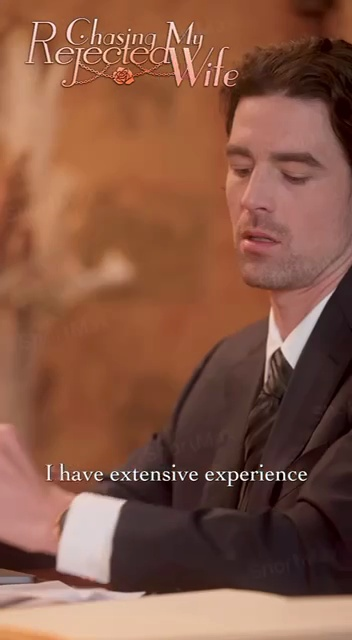

In [19]:
from IPython.display import Image, display

cut_scene_number = 5

# Path to your image file
image_path = scenes_with_captions[cut_scene_number]["frames_metadata"][0]["frame_path"]

# Display the image
display(Image(filename=image_path))

In [20]:
caption_sample = scenes_with_captions[cut_scene_number]["frames_metadata"][0]["caption"]

print(".\n".join(map(lambda x: x.strip(), caption_sample.split("."))))

The setting appears to be a formal indoor environment, likely an office or a conference room.
The person in the image is wearing a suit, suggesting a professional setting.
The background has warm, ambient lighting, with a blurred effect that does not provide distinct details but gives the impression of a sophisticated or upscale space.
There is a desk in front of the person, which aligns with the setting being an office environment.



# *. Characters Classification

## `face_recognition`

By saving the known faces database to a file (`known_faces.pkl`), the agent can maintain consistent person IDs across different runs or sessions.

Each time a new face is encountered, it's added to the database with a new unique ID.

**Enhancements:** 

Faces may appear different due to angles, expressions, or lighting.

To improve recognition, consider augmenting the known face encodings with multiple samples per person from different frames.

In [31]:
# import logging
# import os
# import pickle
# from typing import Dict, List

# import face_recognition
# import numpy as np

In [20]:
# tmp_frame = cv2.imread(
#     "/home/nurba/Desktop/VideoSettingsClassification/frames/scene_2_frame_115.jpg"
# )
# tmp_frame.shape

In [21]:
# rgb_tmp_frame = cv2.cvtColor(tmp_frame, cv2.COLOR_BGR2RGB)
# rgb_tmp_frame.shape

In [22]:
# face_locations = face_recognition.face_locations(rgb_tmp_frame)
# face_encodings = face_recognition.face_encodings(rgb_tmp_frame, face_locations)

In [23]:
# face_locations

In [24]:
# known_face_encodings = [
#     face_encodings[0],
#     face_encodings[0] + np.random.randn(*face_encodings[0].shape),
#     face_encodings[0] + np.random.randn(*face_encodings[0].shape) * 1e-4,
# ]

In [25]:
# matches = face_recognition.compare_faces(
#     known_face_encodings,
#     face_encodings[0],
#     tolerance=0.6,  # 14.6
# )

# matches

In [26]:
# matches.index(True)

In [37]:
# import json

# with open(
#     "./results/scenes_with_captions.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_captions = json.load(json_file)

In [21]:
scenes_with_captions

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting."}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'end_seconds': 5.9,
  'start_frame': 75,
  'end_frame': 177,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_75.jpg']

In [22]:
from agents.characters_classification import CharactersClassificationAgent

In [23]:
characters_classification_agent = CharactersClassificationAgent(
    scenes=scenes_with_captions, known_faces_db="./characters/known_faces.pkl"
)

scenes_with_characters = characters_classification_agent.classify_characters()

In [24]:
scenes_with_characters

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 80,
       'right': 294,
       'bottom': 187,
       'left': 187}}]}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'e

In [26]:
# import json
# import os

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "scenes_with_characters.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(scenes_with_characters, json_file, ensure_ascii=False, indent=4)

**Visualization**

In [ ]:
# import json

# with open(
#     "./results/scenes_with_characters.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_characters = json.load(json_file)

In [28]:
scenes_with_characters[0]

{'start_timecode': '00:00:00.000',
 'end_timecode': '00:00:02.500',
 'start_seconds': 0.0,
 'end_seconds': 2.5,
 'start_frame': 0,
 'end_frame': 75,
 'cut_scene_number': 1,
 'frame_paths': ['frames/scene_1_frame_0.jpg'],
 'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
   'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
   'faces': [{'person_id': 0,
     'face_location': {'top': 80,
      'right': 294,
      'bottom': 187,
      'left': 187}}]}]}

In [29]:
frame_path = scenes_with_characters[0]["frames_metadata"][0]["frame_path"]
frame = cv2.imread(frame_path)

face_data = scenes_with_characters[0]["frames_metadata"][0]["faces"]

text_type = "person_id"

font_scale = 0.5
thickness = 2

In [ ]:
# from visualization_tools.frame_put_text import detect_faces_frame

# annotated_frame = detect_faces_frame(
#     frame=frame,
#     face_data=face_data,
#     text_type=text_type,
#     font_scale=font_scale,
#     thickness=thickness,
# )

# # Save the annotated frame
# annotated_frame_path = f"checking_detect_faces_frame_{text_type}.jpg"
# cv2.imwrite(annotated_frame_path, annotated_frame)

In [73]:
# !rm -r ./frames_person_id

In [30]:
visualization_type = "faces"

text_type = "person_id"

font_scale = 0.5
thickness = 2

In [ ]:
# from visualization_tools.frame_put_text import put_text_frames

# put_text_frames(scenes=scenes_with_characters, visualization_type=visualization_type, text_type=text_type, logger=main_logger, font_scale=font_scale, thickness=thickness)

## `FaceAnalysis`

Replacing the `face_recognition` library with insightface’s `FaceAnalysis` can offer improved performance and accuracy in face detection and recognition tasks. InsightFace provides state-of-the-art models for face analysis, including detection, recognition, alignment, and more.

### testing

In [ ]:
import logging
import os
import pickle
from typing import Dict, List

import cv2
import numpy as np
from insightface.app import FaceAnalysis

In [25]:
app = FaceAnalysis(
    name="buffalo_l", providers=["CoreMLExecutionProvider"]
)  # 'CUDAExecutionProvider' for Linux with CUDA support; 'CoreMLExecutionProvider' for MacOS
app.prepare(ctx_id=0)

Applied providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CoreMLExecutionProvider': {}}
find model: /Users/nurbolatkenbayev/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CoreMLExecutionProvider': {}}
find model: /Users/nurbolatkenbayev/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CoreMLExecutionProvider': {}}
find model: /Users/nurbolatkenbayev/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CoreMLExecutionProvider': {}}
find model: /Users/nurbolatkenbayev/.insightface/

In [26]:
frame_path = "./results_examples/click_truncated/frames/scene_98_frame_7183.jpg"
frame = cv2.imread(frame_path)

faces = app.get(frame)

/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


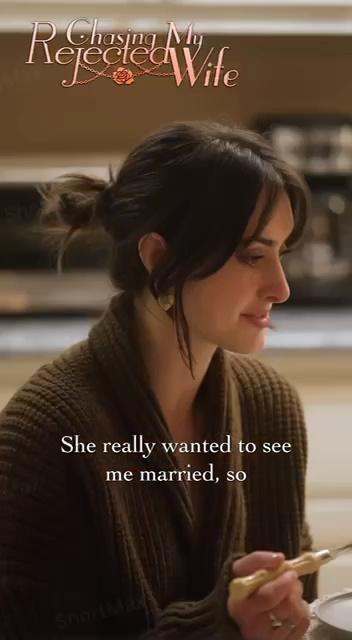

In [27]:
from IPython.display import Image, display

# Display the image
display(Image(filename=frame_path))

In [28]:
len(faces)

1

In [29]:
face = faces[0]

face.keys()

dict_keys(['bbox', 'kps', 'det_score', 'landmark_3d_68', 'pose', 'landmark_2d_106', 'gender', 'age', 'embedding'])

In [30]:
face["gender"]

0

In [31]:
face["age"]

28

In [32]:
face["embedding"].shape

(512,)

In [33]:
face["bbox"]

array([181.78334, 183.05258, 294.0773 , 354.4797 ], dtype=float32)

In [34]:
known_face_embeddings = []
known_face_embeddings.append(face["embedding"])
known_face_embeddings.append(face["embedding"])
known_face_embeddings.append(face["embedding"])
embeddings_array = np.vstack(known_face_embeddings)

embeddings_array.shape

(3, 512)

In [36]:
distances = np.linalg.norm(embeddings_array - face["embedding"], axis=1)
distances

array([0., 0., 0.], dtype=float32)

In [37]:
np.min(distances)

0.0

In [38]:
np.argmin(distances)

0

### main

In [29]:
# import json

# with open(
#     "./results/scenes_with_captions.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_captions = json.load(json_file)

In [30]:
scenes_with_captions

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting."}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'end_seconds': 5.9,
  'start_frame': 75,
  'end_frame': 177,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_75.jpg']

In [31]:
import warnings

from agents.characters_classification import CharactersClassificationAgent

warnings.filterwarnings("ignore")

In [47]:
# !rm -rf ./characters
# !rm -rf ./frames_person_id

In [48]:
characters_classification_threshold = 0.15
providers = ["CoreMLExecutionProvider"]

characters_classification_agent = CharactersClassificationAgent(
    scenes=scenes_with_captions,
    threshold=characters_classification_threshold,
    known_faces_db="./characters/known_faces_insightface.pkl",
    providers=providers,
)
scenes_with_characters = characters_classification_agent.classify_characters()

Applied providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CoreMLExecutionProvider': {}}
find model: /Users/nurbolatkenbayev/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CoreMLExecutionProvider': {}}
find model: /Users/nurbolatkenbayev/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CoreMLExecutionProvider': {}}
find model: /Users/nurbolatkenbayev/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CoreMLExecutionProvider': {}}
find model: /Users/nurbolatkenbayev/.insightface/

In [49]:
scenes_with_characters

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 50,
       'right': 276,
       'bottom': 182,
       'left': 177}}]}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'e

In [51]:
# import json
# import os

# from agents.utils import convert_to_serializable

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "scenes_with_characters.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(
#         convert_to_serializable(scenes_with_characters),
#         json_file,
#         ensure_ascii=False,
#         indent=4,
#     )

**Visualization**

In [53]:
# import json

# with open(
#     "./results/scenes_with_characters.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_characters = json.load(json_file)

In [55]:
scenes_with_characters[0:3]

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 50,
       'right': 276,
       'bottom': 182,
       'left': 177}}]}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'e

In [39]:
# frame_path = scenes_with_characters[0]["frames_metadata"][0]["frame_path"]
# frame = cv2.imread(frame_path)

# face_data = scenes_with_characters[0]["frames_metadata"][0]["faces"]

# text_type = "person_id"

# font_scale = 0.6
# thickness = 1

In [40]:
# from visualization_tools.frame_put_text import detect_faces_frame

# annotated_frame = detect_faces_frame(
#     frame=frame,
#     face_data=face_data,
#     text_type=text_type,
#     font_scale=font_scale,
#     thickness=thickness,
# )

# # Save the annotated frame
# annotated_frame_path = f"checking_detect_faces_frame_{text_type}.jpg"
# cv2.imwrite(annotated_frame_path, annotated_frame)

In [41]:
# !rm -r ./frames_person_id

In [56]:
visualization_type = "faces"

text_type = "person_id"

font_scale = 0.6
thickness = 1

In [58]:
# from visualization_tools.frame_put_text import put_text_frames

# put_text_frames(
#     scenes=scenes_with_characters,
#     visualization_type=visualization_type,
#     text_type=text_type,
#     logger=main_logger,
#     font_scale=font_scale,
#     thickness=thickness,
# )

# 4. Setting classification per person

In [7]:
# import os
# import json

# with open(
#     "./results/scenes_with_characters.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_characters = json.load(json_file)

In [32]:
scenes_with_characters

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 80,
       'right': 294,
       'bottom': 187,
       'left': 187}}]}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'e

In [41]:
# frame1 = scenes_with_characters[1]["frames_metadata"][0]["frame_path"]
# frame2 = scenes_with_characters[3]["frames_metadata"][0]["frame_path"]

In [42]:
# import base64

# import openai
# from dotenv import load_dotenv

In [43]:
# load_dotenv()  # take environment variables from .env.

# openai_api_key = os.getenv("OPENAI_API_KEY")

In [44]:
# def encode_image(image_path: str) -> str:
#     with open(image_path, "rb") as image_file:
#         return base64.b64encode(image_file.read()).decode("utf-8")

In [45]:
# base64_image1 = encode_image(frame1)
# base64_image2 = encode_image(frame2)

In [46]:
# response = openai.chat.completions.create(
#     model="gpt-4o",
#     messages=[
#         {
#             "role": "system",
#             "content": "You are an assistant that compares two images to determine if they show the same setting.",
#         },
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "text",
#                     "text": "Based on the two images given below, determine if they have the same setting. Setting can be defined as a location, where some actions are taking place. If in one video actions are taking place in several places, then there would be several settings. Pay attention to people's pose, hairstyle, clothes, and background lighting. Answer just 'True' or 'False'.",
#                 },
#                 {
#                     "type": "image_url",
#                     "image_url": {
#                         "url": f"data:image/jpeg;base64,{base64_image1}",
#                         "detail": "high",
#                     },
#                 },
#                 {
#                     "type": "image_url",
#                     "image_url": {
#                         "url": f"data:image/jpeg;base64,{base64_image2}",
#                         "detail": "high",
#                     },
#                 },
#             ],
#         },
#     ],
#     max_tokens=300,
# )

In [47]:
# response.choices[0].message.content

In [48]:
# response.choices[0].message.content.lower()

In [49]:
# ans_list = ["true", "true.", "yes", "yes."]
# response.choices[0].message.content.lower() in ans_list

In [50]:
# frame1 = "./input_data/click_girl1.png"
# frame2_list = [
#     "./input_data/click_girl2.png",
#     "./input_data/click_girl3.png",
#     "./input_data/click_girl4.png",
# ]

# ans_list = []
# for frame2 in frame2_list:
#     base64_image1 = encode_image(frame1)
#     base64_image2 = encode_image(frame2)

#     response = openai.chat.completions.create(
#         model="gpt-4o",
#         messages=[
#             {
#                 "role": "system",
#                 "content": "You are an assistant that compares two images to determine if they show the same setting.",
#             },
#             {
#                 "role": "user",
#                 "content": [
#                     {
#                         "type": "text",
#                         "text": "Based on the two images given below, determine if they have the same setting. Setting can be defined as a location, where some actions are taking place. If in one video actions are taking place in several places, then there would be several settings. Pay attention to people's pose, hairstyle, clothes, and background lighting. Answer just 'Yes' or 'No'.",
#                     },
#                     {
#                         "type": "image_url",
#                         "image_url": {
#                             "url": f"data:image/jpeg;base64,{base64_image1}",
#                             "detail": "high",
#                         },
#                     },
#                     {
#                         "type": "image_url",
#                         "image_url": {
#                             "url": f"data:image/jpeg;base64,{base64_image2}",
#                             "detail": "high",
#                         },
#                     },
#                 ],
#             },
#         ],
#         max_tokens=300,
#     )
#     ans_list.append(response.choices[0].message.content)

# ans_list

In [ ]:
import os

from dotenv import load_dotenv

from agents.setting_identification_per_person import SettingClassificationCharacterAgent

In [34]:
load_dotenv()  # take environment variables from .env.

openai_api_key = os.getenv("OPENAI_API_KEY")

In [35]:
# dining (one global setting): 37 frames, 5 characters ~ 2 min

setting_classification_character_agent = SettingClassificationCharacterAgent(
    scenes=scenes_with_characters,
    openai_api_key=openai_api_key,
)

scenes_with_settings_per_character, person_frames = (
    setting_classification_character_agent.cluster_frames()
)

In [36]:
scenes_with_settings_per_character

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 80,
       'right': 294,
       'bottom': 187,
       'left': 187}}]}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'start_seconds': 2.5,
  'e

In [37]:
person_frames

{0: [{'cut_scene_number': 1,
   'frame_path': 'frames/scene_1_frame_0.jpg',
   'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
   'faces': [{'person_id': 0,
     'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187}}],
   'setting_ID': 'person_0_setting_0'},
  {'cut_scene_number': 3,
   'frame_path': 'frames/scene_3_frame_177.jpg',
   'caption': "The setting in the picture is an indoor environment, likely a room with a classic or vintage ambiance. The walls have a patterned design, and there's a framed picture hanging in the background, suggesting a home or 

In [39]:
# import json
# import os

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "person_frames.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(person_frames, json_file, ensure_ascii=False, indent=4)

In [40]:
# Update scene metadata with settings per person

for person_id, frames_data in person_frames.items():
    for data in frames_data:
        cut_scene_number = data["cut_scene_number"]
        scene = scenes_with_settings_per_character[cut_scene_number - 1]
        assert scene["cut_scene_number"] == cut_scene_number

        frames_metadata = scene.get("frames_metadata", [])
        for frame_metadata in frames_metadata:
            if frame_metadata["frame_path"] == data["frame_path"]:
                faces = frame_metadata.get("faces", [])
                if len(faces) == 0:
                    continue
                for face in faces:
                    if face["person_id"] == person_id:
                        face["setting_ID"] = data[
                            "setting_ID"
                        ]  # changes `faces`, so `frames_metadata`, so `scenes_with_settings_per_character`

In [41]:
scenes_with_settings_per_character

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
      'setting_ID': 'person_0_setting_0'}]}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'star

In [43]:
# import json
# import os

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "scenes_with_settings_per_character.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(
#         scenes_with_settings_per_character, json_file, ensure_ascii=False, indent=4
#     )

In [14]:
# import json

# with open(
#     "./results/scenes_with_settings_per_character.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_settings_per_character = json.load(json_file)

In [13]:
scenes_with_settings_per_character

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': 'The image shows a woman standing indoors, possibly in a warmly decorated room. She is wearing a light blouse with a bow at the collar and a light-colored skirt with buttons. The room has a cozy atmosphere with framed pictures on the wall and soft lighting. There\'s a glimpse of a wooden surface, possibly a desk or table, in the foreground. The text on the image reads, "It\'s nice to see you, Mr. Price," and a title at the top says, "Chasing My Rejected Wife."',
    'faces': [{'person_id': 0,
      'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
      'setting_ID': 'person_0_setting_0'}]}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.90

**Visualization**

In [15]:
scenes_with_settings_per_character[0]

{'start_timecode': '00:00:00.000',
 'end_timecode': '00:00:02.500',
 'start_seconds': 0.0,
 'end_seconds': 2.5,
 'start_frame': 0,
 'end_frame': 75,
 'cut_scene_number': 1,
 'frame_paths': ['frames/scene_1_frame_0.jpg'],
 'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
   'caption': 'The image shows a woman standing indoors, possibly in a warmly decorated room. She is wearing a light blouse with a bow at the collar and a light-colored skirt with buttons. The room has a cozy atmosphere with framed pictures on the wall and soft lighting. There\'s a glimpse of a wooden surface, possibly a desk or table, in the foreground. The text on the image reads, "It\'s nice to see you, Mr. Price," and a title at the top says, "Chasing My Rejected Wife."',
   'faces': [{'person_id': 0,
     'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
     'setting_ID': 'person_0_setting_0'}]}]}

In [41]:
frame_path = scenes_with_settings_per_character[0]["frames_metadata"][0]["frame_path"]
frame = cv2.imread(frame_path)

face_data = scenes_with_settings_per_character[0]["frames_metadata"][0]["faces"]

text_type = "person_id_setting_ID"

font_scale = 0.3
thickness = 1

In [18]:
# from visualization_tools.frame_put_text import detect_faces_frame

# annotated_frame = detect_faces_frame(
#     frame=frame,
#     face_data=face_data,
#     text_type=text_type,
#     font_scale=font_scale,
#     thickness=thickness,
# )

# # Save the annotated frame
# annotated_frame_path = f"checking_detect_faces_frame_{text_type}.jpg"
# cv2.imwrite(annotated_frame_path, annotated_frame)

In [20]:
# !rm -r ./frames_person_id_setting_ID

In [44]:
visualization_type = "faces"

text_type = "person_id_setting_ID"

font_scale = 0.4
thickness = 1

In [46]:
# from visualization_tools.frame_put_text import put_text_frames

# put_text_frames(scenes=scenes_with_settings_per_character, visualization_type=visualization_type, text_type=text_type, logger=main_logger, font_scale=font_scale, thickness=thickness)

# 5. Assigning one global setting ID. Merging settings of different characters on the same frame

In [47]:
# import copy
# import logging
# from typing import Dict, List

# import networkx as nx

In [48]:
# graph = nx.Graph()

# graph.add_node(10)
# graph.add_node(20)
# graph.add_node(30)
# graph.add_node(40)
# graph.add_node(50)
# graph.add_node(60)
# graph.add_node(70)
# graph.add_node(100)

# graph.add_edge(10, 100)
# graph.add_edge(20, 30)
# graph.add_edge(30, 50)
# graph.add_edge(10, 40)
# graph.add_edge(100, 40)

# connected_components = list(nx.connected_components(graph))
# print(connected_components)

# graph.add_node(70)
# graph.add_node(70)
# graph.add_node(80)
# connected_components = list(nx.connected_components(graph))
# print(connected_components)

In [6]:
# import json
# import os

# with open(
#     "./results/scenes_with_settings_per_character.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_settings_per_character = json.load(json_file)

In [49]:
scenes_with_settings_per_character

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
      'setting_ID': 'person_0_setting_0'}]}]},
 {'start_timecode': '00:00:02.500',
  'end_timecode': '00:00:05.900',
  'star

In [ ]:
from agents.setting_identification_global import GlobalSettingAssignmentAgent

In [51]:
global_setting_assignment_agent = GlobalSettingAssignmentAgent(
    scenes=scenes_with_settings_per_character,
)

scenes_with_settings_global = global_setting_assignment_agent.assign_global_settings()

In [53]:
# import json
# import os

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "scenes_with_settings_global.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(scenes_with_settings_global, json_file, ensure_ascii=False, indent=4)

In [33]:
# import json

# with open(
#     "./results/scenes_with_settings_global.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_settings_global = json.load(json_file)

In [54]:
scenes_with_settings_global

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
      'setting_ID': 'person_0_setting_0',
      'global_setting_ID': 'global_setting_0'}],
    'global_setting_ID': 'global_

**Visualization**

In [7]:
# import json

# with open(
#     "./results/scenes_with_settings_global.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_settings_global = json.load(json_file)

In [8]:
scenes_with_settings_global[0]

{'start_timecode': '00:00:00.000',
 'end_timecode': '00:00:02.500',
 'start_seconds': 0.0,
 'end_seconds': 2.5,
 'start_frame': 0,
 'end_frame': 75,
 'cut_scene_number': 1,
 'frame_paths': ['frames/scene_1_frame_0.jpg'],
 'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
   'caption': 'The image shows a woman standing indoors, possibly in a warmly decorated room. She is wearing a light blouse with a bow at the collar and a light-colored skirt with buttons. The room has a cozy atmosphere with framed pictures on the wall and soft lighting. There\'s a glimpse of a wooden surface, possibly a desk or table, in the foreground. The text on the image reads, "It\'s nice to see you, Mr. Price," and a title at the top says, "Chasing My Rejected Wife."',
   'faces': [{'person_id': 0,
     'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
     'setting_ID': 'person_0_setting_0',
     'global_setting_ID': 'global_setting_0'}],
   'global_setting_ID': 'global_sett

In [8]:
import cv2

frame_path = scenes_with_settings_global[0]["frames_metadata"][0]["frame_path"]
frame = cv2.imread(frame_path)

text = scenes_with_settings_global[0]["frames_metadata"][0]["global_setting_ID"]


font_scale = 0.5
thickness = 1

In [55]:
# from visualization_tools.frame_put_text import put_text_one_frame

# annotated_frame = put_text_one_frame(
#     frame=frame,
#     text=text,
#     font_scale=font_scale,
#     thickness=thickness,
# )

# # Save the annotated frame
# annotated_frame_path = "checking_put_text_one_frame.jpg"
# cv2.imwrite(annotated_frame_path, annotated_frame)

In [10]:
# !rm -r ./frames_global_setting_ID

In [56]:
visualization_type = "text_global_setting_ID"

text_type = None

font_scale = 0.5
thickness = 1

In [58]:
# from visualization_tools.frame_put_text import put_text_frames

# put_text_frames(
#     scenes=scenes_with_settings_global,
#     visualization_type=visualization_type,
#     text_type=text_type,
#     logger=main_logger,
#     font_scale=font_scale,
#     thickness=thickness,
# )

# 6. Classifying settings based on the global setting ID

In [6]:
import multiprocessing
import os

from dotenv import load_dotenv

from agents.setting_classification import SettingClassifierAgent

In [7]:
load_dotenv()  # take environment variables from .env.

openai_api_key = os.getenv("OPENAI_API_KEY")

In [8]:
num_processes = int(0.8 * multiprocessing.cpu_count())
print(f"Utilizing num_processes = {num_processes}")

Utilizing num_processes = 8


In [12]:
# import json

# with open(
#     "./results/scenes_with_settings_global.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_settings_global = json.load(json_file)

In [13]:
scenes_with_settings_global

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
      'setting_ID': 'person_0_setting_0',
      'global_setting_ID': 'global_setting_0'}],
    'global_setting_ID': 'global_

In [14]:
setting_classification_agent = SettingClassifierAgent(
    num_processes=num_processes,
    scenes=scenes_with_settings_global,
    openai_api_key=openai_api_key,
)

scenes_with_settings_names, global_setting_ID_to_name_dict = (
    setting_classification_agent.classify_settings()
)

In [15]:
scenes_with_settings_names

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:02.500',
  'start_seconds': 0.0,
  'end_seconds': 2.5,
  'start_frame': 0,
  'end_frame': 75,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
    'faces': [{'person_id': 0,
      'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
      'setting_ID': 'person_0_setting_0',
      'global_setting_ID': 'global_setting_0'}],
    'global_setting_ID': 'global_

In [17]:
# import json
# import os

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "scenes_with_settings_names.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(scenes_with_settings_names, json_file, ensure_ascii=False, indent=4)

In [18]:
global_setting_ID_to_name_dict

{'global_setting_0': 'office',
 'global_setting_1': 'living room',
 'global_setting_2': 'office',
 'global_setting_3': 'indoors (home or office)',
 'global_setting_4': 'inside a vehicle',
 'global_setting_5': 'recreation room',
 'global_setting_6': 'billiards room'}

In [20]:
# import json
# import os

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "global_setting_ID_to_name_dict.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(global_setting_ID_to_name_dict, json_file, ensure_ascii=False, indent=4)

**Visualization**

In [7]:
# import json

# with open(
#     "./results/scenes_with_settings_names.json",
#     "r",
#     encoding="utf-8",
# ) as json_file:
#     scenes_with_settings_names = json.load(json_file)

In [8]:
scenes_with_settings_names[0]

{'start_timecode': '00:00:00.000',
 'end_timecode': '00:00:02.500',
 'start_seconds': 0.0,
 'end_seconds': 2.5,
 'start_frame': 0,
 'end_frame': 75,
 'cut_scene_number': 1,
 'frame_paths': ['frames/scene_1_frame_0.jpg'],
 'frames_metadata': [{'frame_path': 'frames/scene_1_frame_0.jpg',
   'caption': "The setting appears to be an indoor space, likely an office or a formal living area. The environment has warm lighting, suggesting a cozy or intimate atmosphere. The background shows framed pictures or artworks on a textured wall. There's a desk lamp partially visible, and a woman is at the forefront, dressed in a formal blouse and skirt, standing with a poised demeanor. The decor and attire give the impression of a professional or elegant setting.",
   'faces': [{'person_id': 0,
     'face_location': {'top': 80, 'right': 294, 'bottom': 187, 'left': 187},
     'setting_ID': 'person_0_setting_0',
     'global_setting_ID': 'global_setting_0'}],
   'global_setting_ID': 'global_setting_0',
   

In [9]:
import cv2

frame_path = scenes_with_settings_names[0]["frames_metadata"][0]["frame_path"]
frame = cv2.imread(frame_path)

text = scenes_with_settings_names[0]["frames_metadata"][0]["global_setting_name"]


font_scale = 0.5
thickness = 1

In [25]:
# from visualization_tools.frame_put_text import put_text_one_frame

# annotated_frame = put_text_one_frame(
#     frame=frame,
#     text=text,
#     font_scale=font_scale,
#     thickness=thickness,
# )

# # Save the annotated frame
# annotated_frame_path = "checking_put_text_one_frame.jpg"
# cv2.imwrite(annotated_frame_path, annotated_frame)

In [11]:
# !rm -r ./frames_global_setting_name

In [12]:
visualization_type = "text_global_setting_name"

text_type = None

font_scale = 0.5
thickness = 1

In [13]:
from visualization_tools.frame_put_text import put_text_frames

put_text_frames(
    scenes=scenes_with_settings_names,
    visualization_type=visualization_type,
    text_type=text_type,
    logger=main_logger,
    font_scale=font_scale,
    thickness=thickness,
)

# Fixed settings list. My handmade labeling (old)

Preparing `json` file for comfortable labeling

In [ ]:
import json


In [85]:
with open("./results/scenes_with_captions.pkl", "rb") as f:
    scenes_with_captions = pickle.load(f)

In [ ]:
scenes_with_handmade_labels = []

# Create a deep copy of the original list to avoid changes in it
scenes_with_captions_copied = copy.deepcopy(scenes_with_captions)
for scene in scenes_with_captions_copied:
    scene_number = scene["cut_scene_number"]
    captions = scene.get("captions", [])

    if not captions:
        print(f"No captions found for Scene {scene_number}. Skipping.")
    else:
        processed_captions = []
        for caption in captions:
            caption["setting"] = ""
            processed_captions.append(caption)

        scene["captions"] = processed_captions

    scenes_with_handmade_labels.append(scene)


In [45]:
dir_path = "./results"
json_file_path = os.path.join(dir_path, "scenes_with_handmade_labels.json")

with open(json_file_path, "w", encoding="utf-8") as json_file:
    json.dump(scenes_with_handmade_labels, json_file, ensure_ascii=False, indent=4)

Loading `possible_settings`

In [82]:
with open(
    "./input_data/possible_settings_minecraft_processed.json", "r", encoding="utf-8"
) as json_file:
    possible_settings_dict = json.load(json_file)

In [83]:
possible_settings = list(possible_settings_dict.keys())
len(possible_settings)

9

In [84]:
possible_settings

['Game Menu: Loading Screen',
 'Game Menu: Pause Menu',
 'Game Menu: Inventory Screen',
 'Overworld: Plains',
 'Overworld: Forest',
 'Overworld: Village',
 'Nether: Nether Wastes',
 'End: The End',
 'Other: Nether Portal']

In [119]:
with open(
    "./results/scenes_with_handmade_labels.json", "r", encoding="utf-8"
) as json_file:
    scenes_with_handmade_labels = json.load(json_file)

In [ ]:
# scenes_with_handmade_labels_lower = []
# for scene in scenes_with_handmade_labels:
#     captions = scene.get("captions", [])
#     if not captions:
#         print(f"No captions found for Scene {scene_number}. Skipping.")
#     else:
#         processed_captions = []
#         for caption in captions:
#             caption["setting"] = caption["setting"].lower()
#             processed_captions.append(caption)

#         scene["captions"] = processed_captions

#     scenes_with_handmade_labels_lower.append(scene)


# dir_path = "./results"
# json_file_path = os.path.join(dir_path, "scenes_with_handmade_labels.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(
#         scenes_with_handmade_labels_lower, json_file, ensure_ascii=False, indent=4
#     )

In [69]:
scenes_with_handmade_labels_copied = copy.deepcopy(scenes_with_handmade_labels)

In [104]:
handmade_labels_list = [
    caption["setting"].lower()
    for scene in scenes_with_handmade_labels_copied
    for caption in scene["captions"]
]
handmade_labels_list

['game menu: loading screen',
 'game menu: loading screen',
 'game menu: pause menu',
 'game menu: pause menu',
 'overworld: plains',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: forest',
 'game menu: inventory screen',
 'other: nether portal',
 'nether: nether wastes',
 'nether: nether wastes',
 'nether: nether wastes',
 'nether: nether wastes',
 'nether: nether wastes',
 'other: nether portal',
 'game menu: loading screen',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'game menu: pause menu']

In [ ]:
assert (
    np.array([item in possible_settings for item in handmade_labels_list]).all()
), "Handmade labeling contains labels outside of the given 'possible_settings' list."

In [80]:
scenes_with_handmade_labels_copied

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:01.458',
  'start_seconds': 0.0,
  'end_seconds': 1.458333325777202,
  'start_frame': 0,
  'end_frame': 35,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'captions': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': 'The image shows a digital interface featuring a block with a rotation option highlighted. Above the block, text reads "World record 1:56," suggesting a recorded time achievement.',
    'setting': 'Game Menu: Loading Screen'}]},
 {'start_timecode': '00:00:01.458',
  'end_timecode': '00:00:08.333',
  'start_seconds': 1.458333325777202,
  'end_seconds': 8.33333329015544,
  'start_frame': 35,
  'end_frame': 200,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_35.jpg'],
  'captions': [{'frame_path': 'frames/scene_2_frame_35.jpg',
    'caption': 'The image shows a digital interface with a label that reads "World record 1:56" at the top. Below, there is a square 

# 4. Setting classification (old)

In [87]:
def classify_frame_setting(
    frame_path: str,
    caption: str,
    possible_settings: List[str],
    openai_api_key: str,
    logger: logging.Logger,
) -> str:
    openai.api_key = openai_api_key  # Set API key in the process

    prompt = (
        f"Based on the following description, classify the setting of the scene into one of the predefined categories.\n\n"
        f"Description: {caption}\n\n"
        f"Possible settings: {', '.join(possible_settings)}\n\n"
        f"Answer format: Only provide the setting name from the list above."
    )
    # Notice specific details and objects in the description classify the setting of the scene into one of the predefined categories
    # thinking about which of these categories most likely will have such objects.
    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an assistant that classifies video frames into predefined settings.",
                },
                {"role": "user", "content": prompt},
            ],
            max_tokens=10,
            n=1,
            stop=None,
            temperature=0.0,
        )

        setting = response.choices[0].message.content.strip().lower()

        # Validate the setting
        if setting not in [s.lower() for s in possible_settings]:
            logger.warning(
                f"Invalid setting '{setting}' received from OpenAI. Setting to 'unknown'."
            )
            setting = "unknown"
        else:
            logger.info(
                f"Predicted setting '{setting}' for frame '{frame_path}' with caption: \n'{caption}'"
            )

        return setting

    except openai.RateLimitError as e:
        logger.error(f"Rate limit error: {e}")
        # Handle rate limit error (e.g., retry after some time)
        return "unknown"

    except Exception as e:
        logger.error(f"Error during OpenAI API call: {e}")
        return "unknown"


def process_frame_setting(
    caption_data: dict,
    possible_settings: List[str],
    openai_api_key: str,
    logger: logging.Logger,
) -> dict:
    caption = caption_data.get("caption", "")
    frame_path = caption_data["frame_path"]
    if caption:
        setting = classify_frame_setting(
            frame_path, caption, possible_settings, openai_api_key, logger
        )
        caption_data["setting"] = setting
    else:
        caption_data["setting"] = "unknown"
    return caption_data

In [88]:
# load_dotenv()  # take environment variables from .env.

# openai_api_key = os.getenv("OPENAI_API_KEY")

In [89]:
# log_folder = "./logs/test_logs"
# os.makedirs(log_folder, exist_ok=True)
# logger = setup_logger(log_folder)

In [90]:
# caption_data = scenes_with_captions[7]["captions"][0]

# possible_settings = [
#     "Park",
#     "School",
#     "Church",
#     "Hospital",
#     "House",
#     "Kitchen",
#     "Police station",
# ]

# caption_data_settings = process_frame_setting(
#     caption_data, possible_settings, openai_api_key, logger
# )

In [91]:
# caption_data_settings

In [92]:
def classify_settings_one_cut_scene(
    scene: dict, possible_settings: List[str], openai_api_key: str
) -> dict:
    log_folder = "./logs/SettingClassifierAgent_logs"
    os.makedirs(log_folder, exist_ok=True)
    logger = setup_logger(log_folder)

    scene_number = scene["cut_scene_number"]
    captions = scene.get("captions", [])

    if not captions:
        logger.warning(
            f"No captions found for Scene {scene_number}. Skipping classification."
        )
        scene["captions"] = []
        return scene

    logger.info(
        f"Classifying settings for Scene {scene_number} with {len(captions)} frames."
    )

    setting_list = []
    for caption in captions:
        frame_setting = process_frame_setting(
            caption, possible_settings, openai_api_key, logger
        )
        setting_list.append(frame_setting)

    # Update scene metadata with captions
    scene["captions"] = setting_list

    logger.info(f"Completed setting classification for Scene {scene_number}.")

    return scene

In [93]:
class SettingClassifierAgent:
    """
    Assigns settings for frames extracted from scenes based on their caption.
    """

    def __init__(
        self,
        num_processes: int,
        scenes: List[Dict],
        possible_settings: List[str],
        openai_api_key: str,
    ):
        self.logger = logging.getLogger("SettingClassifierAgent")
        self.num_processes = num_processes
        self.scenes = scenes
        self.possible_settings = possible_settings
        self.openai_api_key = openai_api_key

    def classify_settings(self) -> List[Dict]:
        """
        Generates settings for each frame in the scenes.

        Returns:
            List[Dict]: Updated scene metadata including settings.
        """
        self.logger.info("Starting setting classification for scenes.")

        # Prepare chunks for multiprocessing
        chunks = [
            (scene, self.possible_settings, self.openai_api_key)
            for scene in self.scenes
        ]

        with multiprocessing.Pool(processes=self.num_processes) as pool:
            results = pool.starmap(classify_settings_one_cut_scene, chunks)

        self.logger.info("Setting classification for all scenes completed.")

        return results

In [94]:
scenes_with_captions

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:01.458',
  'start_seconds': 0.0,
  'end_seconds': 1.458333325777202,
  'start_frame': 0,
  'end_frame': 35,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'captions': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': 'The image shows a digital interface featuring a block with a rotation option highlighted. Above the block, text reads "World record 1:56," suggesting a recorded time achievement.'}]},
 {'start_timecode': '00:00:01.458',
  'end_timecode': '00:00:08.333',
  'start_seconds': 1.458333325777202,
  'end_seconds': 8.33333329015544,
  'start_frame': 35,
  'end_frame': 200,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_35.jpg'],
  'captions': [{'frame_path': 'frames/scene_2_frame_35.jpg',
    'caption': 'The image shows a digital interface with a label that reads "World record 1:56" at the top. Below, there is a square area labeled "100%" with a cursor pointing t

In [97]:
possible_settings

['Game Menu: Loading Screen',
 'Game Menu: Pause Menu',
 'Game Menu: Inventory Screen',
 'Overworld: Plains',
 'Overworld: Forest',
 'Overworld: Village',
 'Nether: Nether Wastes',
 'End: The End',
 'Other: Nether Portal']

In [95]:
load_dotenv()  # take environment variables from .env.

openai_api_key = os.getenv("OPENAI_API_KEY")

In [60]:
# !rm -rf ./logs/SettingClassifierAgent_logs

In [96]:
num_processes = int(0.7 * multiprocessing.cpu_count())
print(f"Utilizing num_processes = {num_processes}")

Utilizing num_processes = 28


In [98]:
setting_classifier_agent = SettingClassifierAgent(
    num_processes=num_processes,
    scenes=scenes_with_captions,
    possible_settings=possible_settings,
    openai_api_key=openai_api_key,
)
scenes_with_settings = setting_classifier_agent.classify_settings()

In [99]:
scenes_with_settings

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:01.458',
  'start_seconds': 0.0,
  'end_seconds': 1.458333325777202,
  'start_frame': 0,
  'end_frame': 35,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'captions': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': 'The image shows a digital interface featuring a block with a rotation option highlighted. Above the block, text reads "World record 1:56," suggesting a recorded time achievement.',
    'setting': 'game menu: pause menu'}]},
 {'start_timecode': '00:00:01.458',
  'end_timecode': '00:00:08.333',
  'start_seconds': 1.458333325777202,
  'end_seconds': 8.33333329015544,
  'start_frame': 35,
  'end_frame': 200,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_35.jpg'],
  'captions': [{'frame_path': 'frames/scene_2_frame_35.jpg',
    'caption': 'The image shows a digital interface with a label that reads "World record 1:56" at the top. Below, there is a square area

In [115]:
# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "scenes_with_settings_predicted.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(scenes_with_settings, json_file, ensure_ascii=False, indent=4)

# Computing metrics

## Minecraft metrics (old)

In [14]:
import copy
import json

import numpy as np

In [15]:
with open(
    "./results/scenes_with_handmade_labels.json", "r", encoding="utf-8"
) as json_file:
    scenes_with_handmade_labels = json.load(json_file)

# scenes_with_handmade_labels_copied = copy.deepcopy(scenes_with_handmade_labels)

In [16]:
with open(
    "./results/scenes_with_settings_predicted_simple_prompts2.json",
    "r",
    encoding="utf-8",
) as json_file:
    scenes_with_settings_predicted = json.load(json_file)

In [ ]:
handmade_labels_list = []
predicted_list = []

# Create a deep copy of the original list to avoid changes in it
scenes_with_handmade_labels_copied = copy.deepcopy(scenes_with_handmade_labels)
scenes_with_settings_predicted_copied = copy.deepcopy(scenes_with_settings_predicted)
for i, scene in enumerate(scenes_with_handmade_labels_copied):
    scene_number = scene["cut_scene_number"]
    captions = scene.get("captions", [])

    if not captions:
        print(f"No captions found for Scene {scene_number}. Skipping.")
    else:
        for j, caption in enumerate(captions):
            handmade_labels_list.append(caption["setting"])
            predicted_list.append(
                scenes_with_settings_predicted_copied[i]["captions"][j]["setting"]
            )

In [18]:
print(
    "Accuracy: {:.2f}%".format(
        sum(np.array(handmade_labels_list) == np.array(predicted_list))
        / len(predicted_list)
        * 100.0
    )
)

Accuracy: 79.41%


**Cohen’s Kappa** is a statistic that measures inter-rater agreement for categorical items. It is generally thought to be a more robust measure than simple percent agreement calculation because it takes into account the agreement occurring by chance.

Cohen’s Kappa values can be interpreted as follows (although interpretations may vary):

- kappa <= 0 : No agreement
- 0.01 <= kappa <= 0.20 : Slight agreement
- 0.21 <= kappa <= 0.40 : Fair agreement
- 0.41 <= kappa <= 0.60 : Moderate agreement
- 0.61 <= kappa <= 0.80 : Substantial agreement
- 0.81 <= kappa <= 1.00 : Almost perfect agreement

In [19]:
from sklearn.metrics import cohen_kappa_score


def calculate_cohens_kappa(true_labels, predicted_labels):
    """
    Calculates Cohen's Kappa between two lists of labels.

    Args:
        true_labels (List[str]): The list of true labels.
        predicted_labels (List[str]): The list of predicted labels.

    Returns:
        float: The Cohen's Kappa score.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError(
            "The length of true_labels and predicted_labels must be the same."
        )

    kappa = cohen_kappa_score(true_labels, predicted_labels)
    return kappa

In [20]:
calculate_cohens_kappa(handmade_labels_list, predicted_list)

0.75

**Experiments:**

1. Simple prompts:

   Accuracy = 82.35%

   Cohen’s Kappa = 0.786


2. Simple prompts2:

   Accuracy = 79.41%

   Cohen’s Kappa = 0.75